In [17]:
#Import des librairies nécessaire au projet (cela peut évoluer)
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from numpy import sqrt
import warnings

warnings.filterwarnings('ignore')  # Pour éviter les alertes inutiles

In [18]:
#Chargement de fichier JSON contenant les event de matchs
with open("15946.json", encoding="utf-8") as f:
    data = json.load(f)

In [19]:
#Convertir en dataframe pour faciliter l'analyse
df = pd.json_normalize(data)

In [20]:
#Filtrage des évenements concernant le joueur ciblé: Lionel Andrés Messi Cuccittini
player_name = "Lionel Andrés Messi Cuccittini"
player_df = df[df['player.name'] == player_name].copy()
player_df = player_df.dropna(subset=['location'])  # Suppression des lignes sans coordonnées

In [21]:
#Extraction des coordonnées X/Y depuis le champ 'location'
player_df[['x', 'y']] = pd.DataFrame(player_df['location'].tolist(), index=player_df.index)

In [22]:
#Application d’un clustering KMeans pour identifier les zones d’activité principales
kmeans = KMeans(n_clusters=3, random_state=42)
player_df['cluster'] = kmeans.fit_predict(player_df[['x', 'y']])

In [23]:
#Comptage des différents types d’actions effectuées par la joueuse
action_counts = player_df['type.name'].value_counts()

In [24]:
#Sélection des passes de la joueuse pour créer des indicateurs avancés
passes = df[(df['type.name'] == 'Pass') & (df['player.name'] == player_name)].copy()
passes = passes.dropna(subset=['location', 'pass.end_location'])

In [25]:
#Calcul de la longueur de chaque passe (distance entre point de départ et d’arrivée)
passes['pass_length'] = passes.apply(lambda row: sqrt(
    (row['pass.end_location'][0] - row['location'][0])**2 +
    (row['pass.end_location'][1] - row['location'][1])**2
), axis=1)

In [26]:
#Définition des passes "progressives" comme étant > 15 mètres
passes_progressives = passes[passes['pass_length'] > 15]

In [27]:
#Calcul de la position moyenne du joueur sur le terrain
avg_x, avg_y = player_df['x'].mean(), player_df['y'].mean()

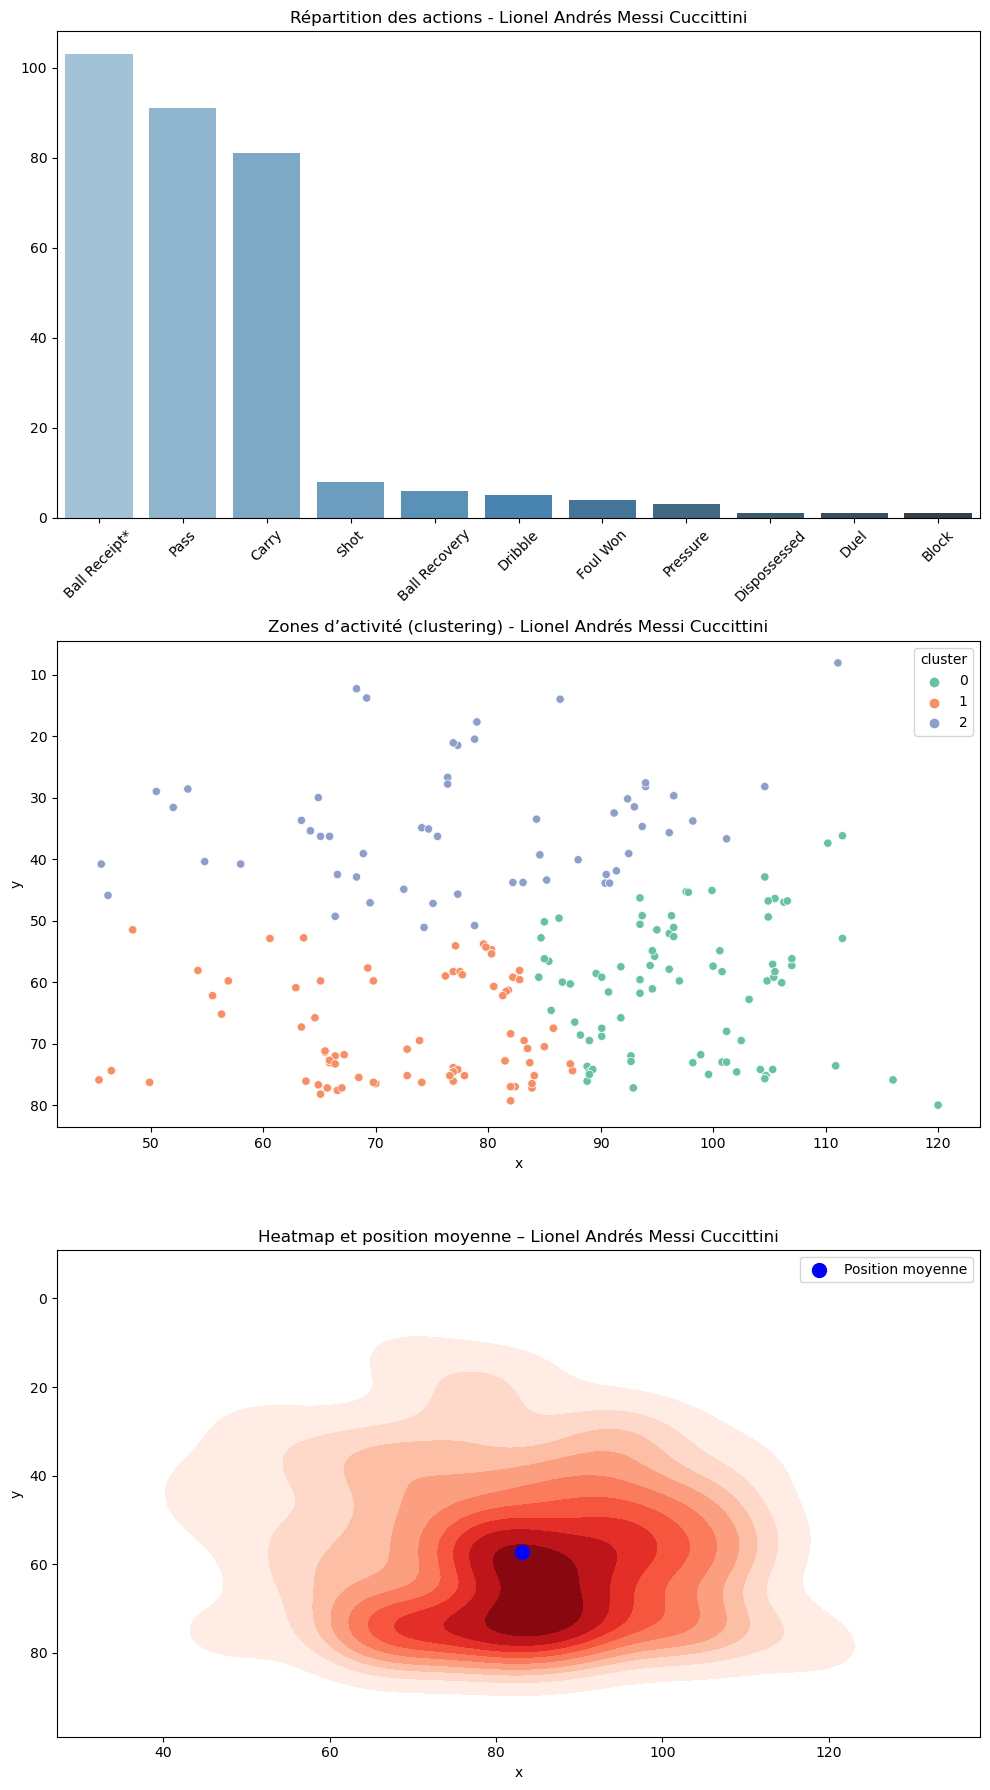

In [30]:
#Création des visualisations
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

#Graphique 1 : répartition des types d’actions
sns.barplot(x=action_counts.index, y=action_counts.values, palette='Blues_d', ax=axes[0])
axes[0].set_title(f"Répartition des actions - {player_name}")
axes[0].tick_params(axis='x', rotation=45)

#Graphique 2 : zones d’activité identifiées par clustering
sns.scatterplot(data=player_df, x='x', y='y', hue='cluster', palette='Set2', ax=axes[1])
axes[1].invert_yaxis()  # Inversion pour correspondre à l’orientation du terrain
axes[1].set_title(f"Zones d’activité (clustering) - {player_name}")

#Graphique 3 : heatmap de présence + position moyenne
sns.kdeplot(x=player_df['x'], y=player_df['y'], fill=True, cmap="Reds", ax=axes[2])
axes[2].scatter(avg_x, avg_y, c='blue', s=100, label='Position moyenne')
axes[2].invert_yaxis()
axes[2].set_title(f"Heatmap et position moyenne – {player_name}")
axes[2].legend()

plt.tight_layout()
plt.show()

In [31]:
#Résumé chiffré à inclure dans ton storytelling
print(f"Nombre total de passes : {len(passes)}")
print(f"Nombre de passes progressives (>15m) : {len(passes_progressives)}")
print(f"Longueur moyenne des passes progressives : {round(passes_progressives['pass_length'].mean(), 2)} m")

Nombre total de passes : 91
Nombre de passes progressives (>15m) : 43
Longueur moyenne des passes progressives : 27.95 m
